In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
#df_results = pd.read_csv("../Results/InvestmentModelResults_2/storage_heavy_red_geo_fsoc_BE00_8760_reformed_2.csv")
#df_results = pd.read_csv("../Results/InvestmentModelResults_2/storage_heavy_red_geo_fsoc_SE03_8760.csv")

df_results_1 = pd.read_csv("../Results/InvestmentModelResults_2/storage_heavy_red_geo_fsoc_BE00_8760_reformed_2.csv")
df_results_2 = pd.read_csv("../Results/InvestmentModelResults_2/storage_heavy_red_geo_fsoc_BE00_8760_reformed_3.csv")
df_results = pd.concat([df_results_1,df_results_2])

In [12]:
#Export revenues and congestion rents should be dealt with with opposite signs
neg_components = ["cong_rent_e","export_rev","cong_rent_i"]
df_results[neg_components] = -df_results[neg_components]

#Split congestion rents equally between neighbors
rents = ['cong_rent_i', 'cong_rent_e']
df_results[rents] = df_results[rents]/2

#Combine operational cost components 
operational_costs = ['CO2_cost', 'load_shedding_cost', 'VOM_cost', 'fuel_cost']
df_results["Operational costs"] = df_results[operational_costs].sum(axis=1)

cost_vals = ['CO2_cost', 'load_shedding_cost', 'VOM_cost', 'fuel_cost','investment_cost', 'export_rev',"import_cost", 'cong_rent_i', 'cong_rent_e']
df_results["Total cost"] = df_results[cost_vals].sum(axis=1)

trade_cost_vals = ['export_rev',"import_cost", 'cong_rent_i', 'cong_rent_e']
df_results["Total trade cost"] = df_results[trade_cost_vals].sum(axis=1)

#Add net import 
df_results["Net import"] = df_results["imported"] - df_results["exported"]

#Add load shedding 
df_results["Load shedding"] = df_results["load_shedding_cost"]/8000

#Add total production
df_results["Total production"] = df_results["w_off_prod"]+ df_results["w_on_prod"]+ df_results["PV_prod"]+df_results["CCGT_prod"]+df_results["OCGT_prod"]

In [13]:
def create_model_type_name(row,columns):
    strings = [str(row[col]) for col in columns if pd.notna(row[col])]
    return '-'.join(strings)

In [14]:
# Assuming df is your DataFrame
new_column_names = {
    'CY': 'CY',
    'CY_ts': 'CY_ts',
    'VOLL': 'VOLL',
    'type': 'type',
    'simplified': 'simplified',
    'investment_cost': 'investment cost',
    'CCGT': 'CCGT',
    'OCGT': 'OCGT',
    'PV': 'PV',
    'w_on': 'w_on',
    'w_off': 'w_off',
    'CCGT_prod': 'CCGT prod',
    'OCGT_prod': 'OCGT prod',
    'PV_prod': 'PV prod',
    'w_on_prod': 'w_on prod',
    'w_off_prod': 'w_off prod',
    'imported': 'imported',
    'exported': 'exported',
    'import_cost': 'import cost',
    'export_rev': 'export revenue',
    'cong_rent_i': 'congestion rent import',
    'cong_rent_e': 'congestion rent export',
    'demand': 'demand',
    'peak_demand': 'peak demand',
    'nb_techs_neighbours': 'nb techs neighbours',
    'time_solve': 'time solve',
    'time_build': 'time build',
    'time_TC': 'time TC',
    'Operational costs': 'Operational costs',
    'Total cost': 'Total cost',
    'Net import': 'Net import',
    'Load shedding': 'Load shedding',
    'Total production': 'Total production',
    'name': 'name',
    'Model Type': 'Model Type'
}

df_results.rename(columns=new_column_names, inplace=True)

In [15]:
##Start with some renaming for clarity 
geo_scope_map = {
    'DE00_NL00_FR00_UK00_BE00_LUG1': 'DN',
    'N_A': '',
    "A_l_l":"All"
}
df_results["geoscope_m"] = df_results["geoscope"].map(geo_scope_map)

# List of columns to consider for joining
columns_to_join = ['type', 'trans_cap_other', 'geoscope_m', 'stepsize',"target_cap_for_curves","simplified"]

# Apply the function row-wise to create the new column
df_results['name'] = df_results.apply(create_model_type_name, args=(columns_to_join,), axis=1)

name_map = {
    "NTC-S-All-True":"NTC-NS",
    "NTC-S-All-False":"NTC-S",
    "TCS-100.0-endo_invest-False":"TCS-S-BM",
    "TCS-100.0-TYNDP-False":"TCS-S-TYNDP",
    "TCS-100.0-0-False":"TCS-S-0",
    "TCS-100.0-no_fix-False":"TCS-S-no fix",
    "NTC-1.00E+10-All-False": "SN-S",
}
df_results['Model Type'] = df_results["name"].replace(name_map)


In [16]:
df_results["Model Type"]

0     NTC-S-False
1    TCS-S-no fix
0     TCS-S-TYNDP
1        TCS-S-BM
2         TCS-S-0
Name: Model Type, dtype: object

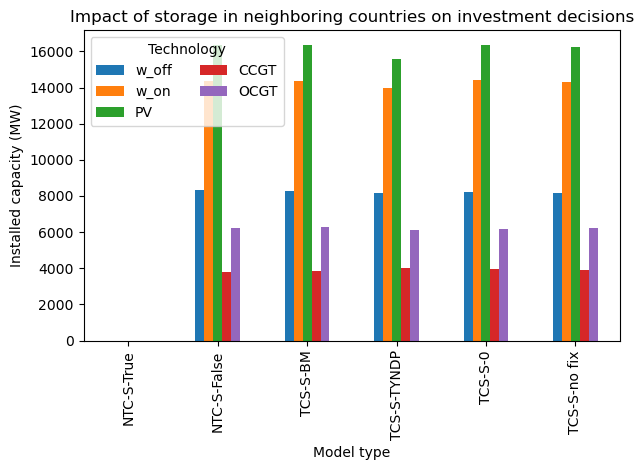

In [17]:
## Plot installed capacities 

# Define the types to include and order in which you want the types to appear
type_order = ["NTC-S-True","NTC-S-False","TCS-S-BM","TCS-S-TYNDP","TCS-S-0","TCS-S-no fix"]
filter_condition = df_results["Model Type"].isin(type_order)

filtered_df = df_results[filter_condition].set_index("Model Type").reindex(type_order).reset_index()

#Choose the values to be displayed
stacked = False
if stacked: 
    vals= ["CCGT", "OCGT","PV","w_on","w_off"]
else:
    vals = [ "w_off", "w_on","PV","CCGT", "OCGT"]
#vals = ["imported","exported"]


filtered_df.plot.bar(x="Model Type", y=vals, stacked=stacked)

plt.xlabel('Model type')
plt.ylabel('Installed capacity (MW)')
plt.title('Impact of storage in neighboring countries on investment decisions')
plt.legend(title='Technology',ncols =2)
plt.tight_layout()

#plt.show()
plt.savefig(f"../Results/Figures/FY_analysis/StorageHeavy/Installed_capacities_bar_{stacked}.png")

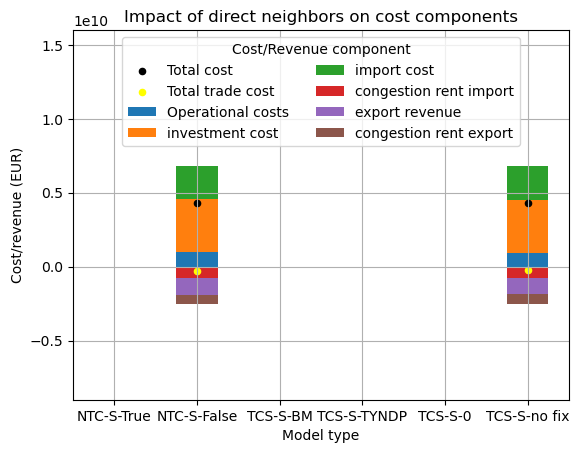

In [9]:
## Plot cost components 

# Define the types to include and order in which you want the types to appear
type_order = ["NTC-S-True","NTC-S-False","TCS-S-BM","TCS-S-TYNDP","TCS-S-0","TCS-S-no fix"]
filter_condition = df_results["Model Type"].isin(type_order)
filtered_df = filtered_df = df_results[filter_condition].set_index("Model Type").reindex(type_order).reset_index()


fig, ax = plt.subplots(1)

vals = ["Operational costs",
       'investment cost', "import cost", 'congestion rent import','export revenue', 'congestion rent export']
vals_tot = vals
#vals_tot = "Total cost"

#vals = ["imported","exported"]

stacked = True
filtered_df.plot.bar(x="Model Type", y=vals_tot, stacked=stacked,ax = ax)

# Scatter plot for multiple columns with different colors
scatter_columns = ['Total cost', 'Total trade cost']
colors = ['black', 'yellow']  # Define colors for each scatter plot

for col, color in zip(scatter_columns, colors):
    filtered_df.plot.scatter(x="Model Type", y=col, ax=ax, label=col, color=color)
# filtered_df.plot.scatter(x="Model Type", y=["Total cost","Total cost"],ax = ax)
# filtered_df.plot.scatter(x="Model Type", y="Total trade cost",ax = ax,label = "Total cost")

plt.xlabel('Model type')
plt.ylabel('Cost/revenue (EUR)')
plt.title('Impact of direct neighbors on cost components')
plt.legend(title='Cost/Revenue component',ncols = 2,loc = "upper center")
if stacked: 
    plt.ylim((-9e9,16e9))    
else: 
    plt.ylim((-6e9,12e9))
plt.grid(True)  # Adding grid


#plt.show()
plt.savefig(f"../Results/Figures/FY_analysis/StorageHeavy/Cost_components_bar_s{stacked}_IDN.png")

In [10]:
df_results["Total cost"],df_results["Model Type"]

(0    4.285574e+09
 1    4.287776e+09
 Name: Total cost, dtype: float64,
 0     NTC-S-False
 1    TCS-S-no fix
 Name: Model Type, dtype: object)